In [1]:
# Load and listen to the audio file
import librosa
import IPython.display as ipd

# Specify the path to the audio file
audiofilepath= './timit-dataset/data/TEST/DR1/FAKS0/SA2.WAV.wav'
print(audiofilepath)

# Load the audio file
audio, sample_rate = librosa.load(audiofilepath)

# Play the audio file in the notebook
ipd.display(ipd.Audio(data=audio, rate=sample_rate))


./timit-dataset/data/TEST/DR1/FAKS0/SA2.WAV.wav


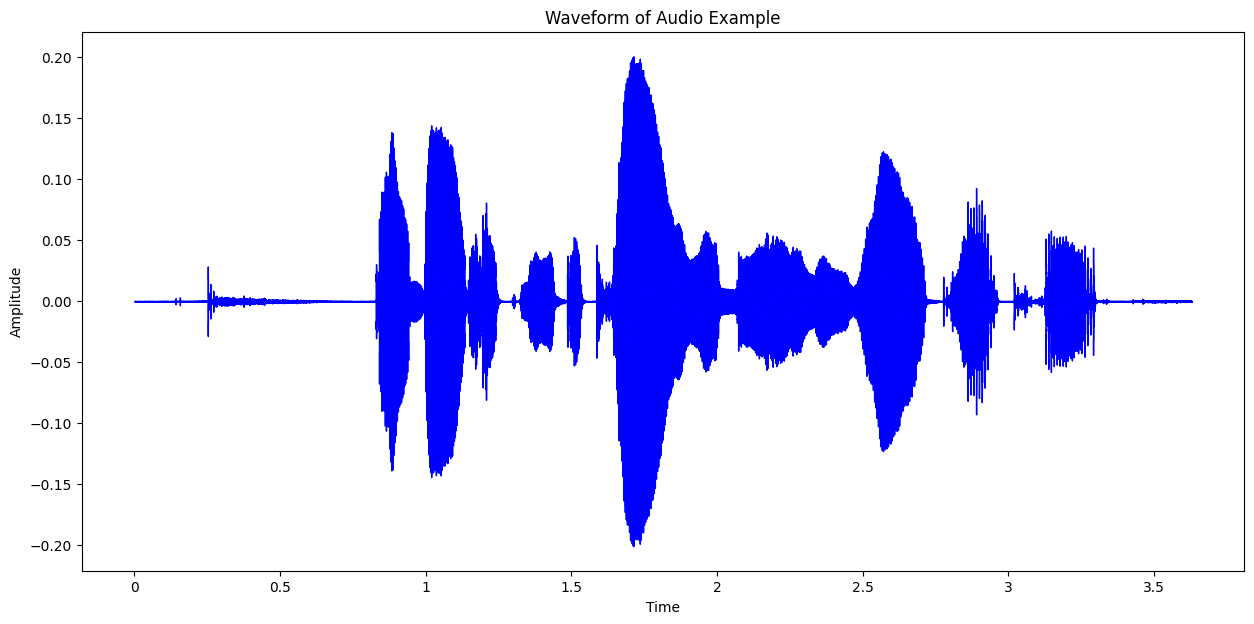

In [2]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt

# Plot our example audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveshow(audio, color='blue')

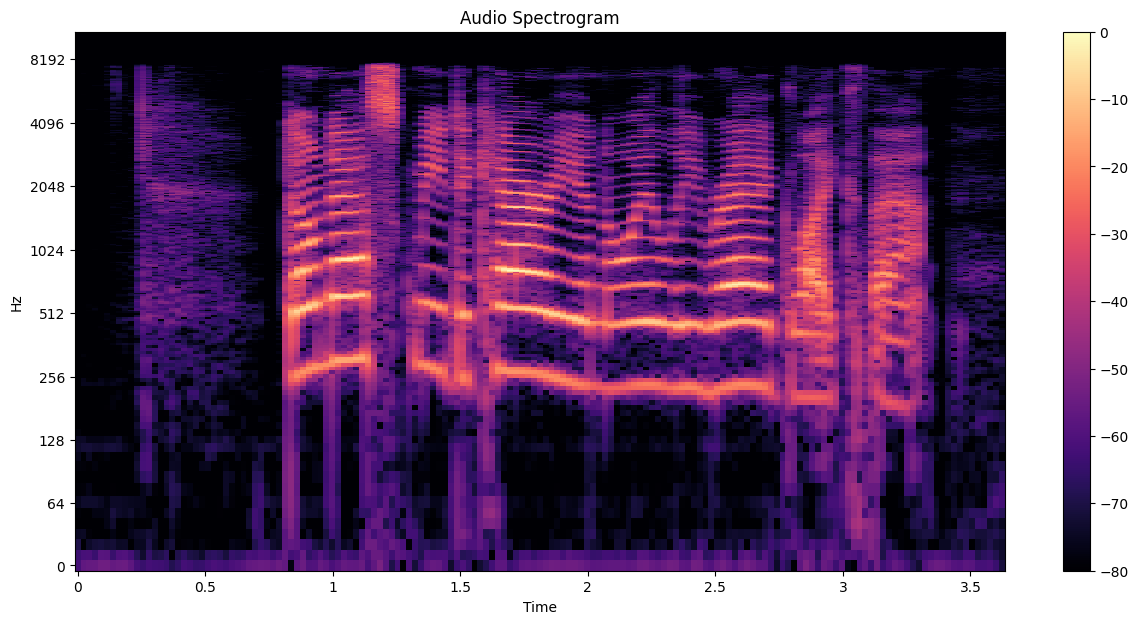

In [3]:
import numpy as np

# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

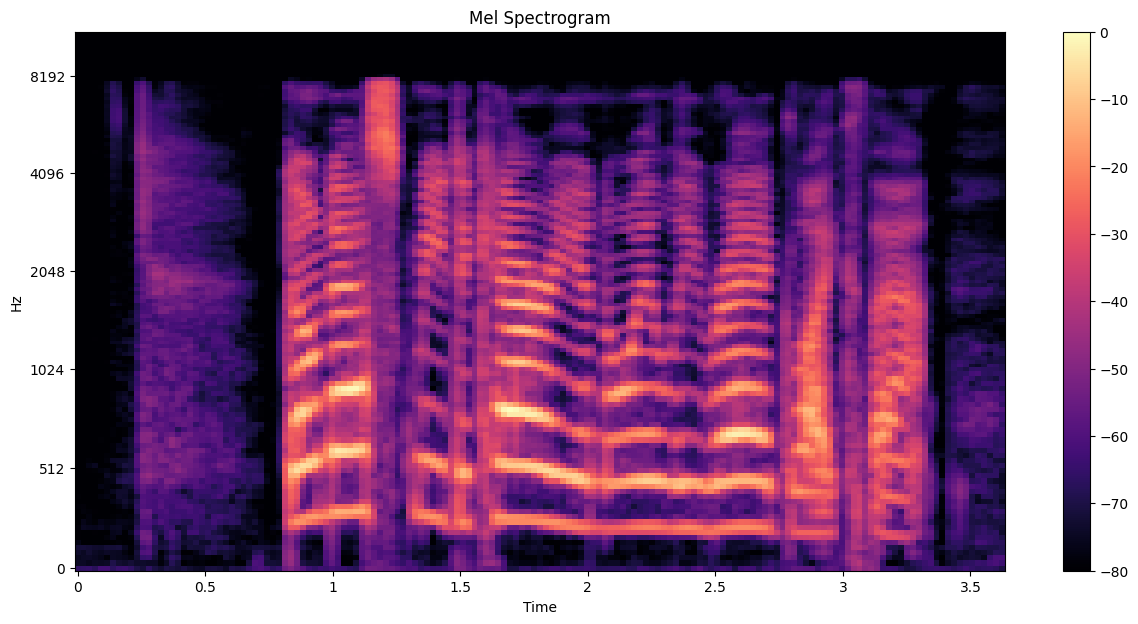

In [4]:
mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram');

In [5]:
import nemo.collections.asr as nemo_asr
import os

squeezeformer_checkpoint_path = "./checkpoints/squeezeformer-xs-ctc-bpe"
if not os.path.exists(squeezeformer_checkpoint_path):
    asr_model = nemo_asr.models.EncDecCTCModelBPE.from_pretrained(model_name="stt_en_squeezeformer_ctc_xsmall_ls")
    asr_model.save_to(squeezeformer_checkpoint_path)
asr_model = nemo_asr.models.EncDecCTCModelBPE.restore_from(squeezeformer_checkpoint_path)

[NeMo I 2024-06-25 16:22:38 mixins:172] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2024-06-25 16:22:39 modelPT:176] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data/tarred_train/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 32
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 16.7
    min_duration: 0.1
    is_tarred: true
    tarred_audio_filepaths: /data/tarred_train/audio__OP_0..511_CL_.tar
    shuffle_n: 2048
    bucketing_strategy: synced_randomized
    bucketing_batch_size: null
    
[NeMo W 2024-06-25 16:22:39 modelPT:183] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath:
    - /data

[NeMo I 2024-06-25 16:22:39 features:305] PADDING: 0
[NeMo I 2024-06-25 16:22:41 save_restore_connector:263] Model EncDecCTCModelBPE was successfully restored from /home/robert/uni/ASRTest/checkpoints/squeezeformer-xs-ctc-bpe.


In [6]:
asr_model.transcribe(audio=audiofilepath)

Transcribing: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it]


["don't ask me to carry an oily rag like that"]

In [18]:
import os


def read_timit_test_txt_files(base_path):
    txt_audio_contents = []
    
    test_path = os.path.join(base_path, 'TEST', 'DR1')
    
    # Iterate over each speaker folder in DR1
    for speaker_folder in os.listdir(test_path):
        speaker_folder_path = os.path.join(test_path, speaker_folder)
        
        if os.path.isdir(speaker_folder_path):
            # Iterate over each file in the speaker's folder
            for file_name in os.listdir(speaker_folder_path):
                if file_name.endswith('.TXT'):
                    txt_path = os.path.join(speaker_folder_path, file_name)
                    
                    # Read the content of the TXT file
                    with open(txt_path, 'r') as file:
                        content = file.read()
                        # Process the content to remove leading numbers and newlines
                        content = ' '.join(content.split()[2:]).strip()
                        
                        # Remove trailing punctuation if it exists
                        if content and content[-1] in '.?!':
                            content = content[:-1].strip()
                    
                    # Get the corresponding WAV file path
                    wav_file_name = file_name.replace('.TXT', '.WAV.wav')
                    wav_path = os.path.join(speaker_folder_path, wav_file_name)
                    
                    if os.path.exists(wav_path):
                        # Append the content and file path to the result list
                        txt_audio_contents.append((content, wav_path))
    
    return txt_audio_contents




In [19]:
import json
base_path = './timit-dataset/data'
txt_files = read_timit_test_txt_files(base_path)
manifest_path = "./timit-dataset/test-manifest.json"
with open(manifest_path, 'w') as fout:
    
    for transcript, audiofilepath in txt_files:
        duration = librosa.core.get_duration(filename=audiofilepath)
        metadata = {
            "audio_filepath": audiofilepath,
            "duration": duration,
            "text": transcript
        }
        json.dump(metadata, fout)
        fout.write('\n')


[NeMo W 2024-06-25 17:02:50 nemo_logging:349] /tmp/ipykernel_571898/3335549898.py:8: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
    	This alias will be removed in version 1.0.
      duration = librosa.core.get_duration(filename=audiofilepath)
    


In [31]:
from nemo.collections.asr.metrics.wer import word_error_rate

# Function to read the manifest file
def read_manifest(manifest_path):
    with open(manifest_path, 'r') as f:
        lines = f.readlines()
    return [json.loads(line.strip()) for line in lines]

# Path to your test manifest file
test_manifest_path = "./timit-dataset/test-manifest.json"

# Read the test manifest file
test_data = read_manifest(test_manifest_path)

# Run inference on the test set
predictions = []
references = []
count = 0
for item in test_data:

    # if count > 1:
    #      break
    # count += 1
    audio_filepath = item['audio_filepath']
    reference_text = item['text'].lower()
    
    # Get the model's prediction
    prediction = asr_model.transcribe([audio_filepath])[0]
    
    # Append predictions and references for WER calculation
    print(f"""
                reference : {reference_text}         
                prediction: {prediction}
""")
    predictions.append(prediction)
    references.append(reference_text)

# Calculate WER
wer = word_error_rate(hypotheses=predictions, references=references)
print(f"Word Error Rate (WER): {wer}")


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]



                reference : she had your dark suit in greasy wash water all year         
                prediction: she had your darck suit in greasy washwater all year



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]



                reference : don't do charlie's dirty dishes         
                prediction: don't do charlie's dirty dishes



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]


                reference : the morning dew on the spider web glistened in the sun         
                prediction: the morning dew on the spider web glistened in the sun




Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]



                reference : cheap stockings run the first time they're worn         
                prediction: cheap stockings run the first time theyre are worn



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]


                reference : a woman met a famous author at a literary tea         
                prediction: a woman met a famous author at a literary tea




Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]



                reference : at the base of the rocky hillside, they left their horses and climbed on foot         
                prediction: at the base of the rocky hillside they left their horses and climbed on foot



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


                reference : objects made of pewter are beautiful         
                prediction: objects made of pewter are beautiful


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]



                reference : calcium makes bones and teeth strong         
                prediction: calsium makes bones and teeth strong



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


                reference : you young men get to be my age, you won't take flu so lightly         
                prediction: you young men get to be my age you won't take flue so lightly




Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]



                reference : don't ask me to carry an oily rag like that         
                prediction: don't ask me to carry an oily rag like that



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]



                reference : the cat's meow always hurts my ears         
                prediction: the cats me out always hurts my ears



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]



                reference : she had your dark suit in greasy wash water all year         
                prediction: she had your dark suit and greasy wash water all year



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]



                reference : jane may earn more money by working hard         
                prediction: jane may earn more money by working hard



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]



                reference : here, he is, quite persuasively, the very embodiment of meanness and slyness         
                prediction: here he is quite persuasively the very embodiment of meanness and slyness



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]



                reference : my father ran him off here six years ago         
                prediction: my father rn him off here six years ago



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]



                reference : dances alternated with sung or spoken verses         
                prediction: dances alternated with sung or spoken verses



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]



                reference : youngsters love common candy as treats         
                prediction: youngsters love common candy as treats



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]



                reference : don't ask me to carry an oily rag like that         
                prediction: don't ask me to carry an oily rag like that



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]



                reference : cliff was soothed by the luxurious massage         
                prediction: cliff was soothed by the luxurious message



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]



                reference : each untimely income loss coincided with the breakdown of a heating system part         
                prediction: each untimely income loss coincided with the break down of a heating system part



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]



                reference : she had your dark suit in greasy wash water all year         
                prediction: she had yo dark suit in greasy wash water all year



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]



                reference : a muscular abdomen is good for your back         
                prediction: a muscular abdimen is good for you back



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]



                reference : however, the litter remained, augmented by several dozen lunchroom suppers         
                prediction: however the litter remained augmented by several dozen lunchroom suppers



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]



                reference : to many experts, this trend was inevitable         
                prediction: to many experts this tran was inevitable



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]



                reference : don't ask me to carry an oily rag like that         
                prediction: don't ask me to carry an oily rag like that



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]



                reference : books are for schnooks         
                prediction: books a a shnoks



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]



                reference : pizzerias are convenient for a quick lunch         
                prediction: pezareas are convenient for a quick lunch



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]



                reference : she had your dark suit in greasy wash water all year         
                prediction: she had your dark suit and greasy wash water all year



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]



                reference : put the butcher block table in the garage         
                prediction: put the butcher block table in the garrache



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]



                reference : her wardrobe consists of only skirts and blouses         
                prediction: her wardrobe consists of only skirts and blouses



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]



                reference : production may fall far below expectations         
                prediction: production may fall far below expectations



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


                reference : his captain was thin and haggard and his beautiful boots were worn and shabby         
                prediction: his captain was thin and haggard and his beautiful boots were worn and shabby




Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]



                reference : elderly people are often excluded         
                prediction: elderly people are often excluded



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]



                reference : don't ask me to carry an oily rag like that         
                prediction: don't ask me to carry an oily rag like that



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]



                reference : the reasons for this dive seemed foolish now         
                prediction: the reasons for the stive seemed foolish now



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]



                reference : drop five forms in the box before you go out         
                prediction: drop five forms in the box before you go out



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]



                reference : she had your dark suit in greasy wash water all year         
                prediction: she had your dark suit and greasy wash water all year



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]



                reference : where were you while we were away         
                prediction: where were you while we were away



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]



                reference : alice's ability to work without supervision is noteworthy         
                prediction: alice's ability to work without supervision is notworthy



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]



                reference : bob papered over living room murals         
                prediction: by a paper over living of mureles



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]



                reference : the heavens refused to give up their weeping         
                prediction: the heavens refused to give up their weeping



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]



                reference : medieval society was based on hierarchies         
                prediction: but eeval society was based on hierarchies



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]



                reference : the idea of a central tank with lines to each house is not in itself a novelty         
                prediction: the idea of a central tank reliines each house is not in itself a novelty



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]



                reference : don't ask me to carry an oily rag like that         
                prediction: don't ask me to carry an eorly rag like that



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]



                reference : you took me by surprise         
                prediction: he took me by surprise



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]



                reference : destroy every file related to my audits         
                prediction: destroy of me far related to my audence



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]



                reference : artificial intelligence is for real         
                prediction: artificial intelligence is for real



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]



                reference : she had your dark suit in greasy wash water all year         
                prediction: she had your dark suit and greasy washwater all year



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]



                reference : only the most accomplished artists obtain popularity         
                prediction: only the most accomplished artists obtain popularity



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]



                reference : in wage negotiations, the industry bargains as a unit with a single union         
                prediction: in wage negotiations the industry bargains as a unit with a single union



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]



                reference : materials: ceramic modeling clay: red, white or buff         
                prediction: materials syremic modelling clay red white or buff



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]



                reference : the fish began to leap frantically on the surface of the small lake         
                prediction: the fish began to leap frantically on the surface of the small lake



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]



                reference : heave on those ropes; the boat's come unstuck         
                prediction: heave on those ropes the boats come unstuck



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]



                reference : don't ask me to carry an oily rag like that         
                prediction: don't ask me to carry an oily rag like that



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]



                reference : a chosen few will become generals         
                prediction: a chosen few will become generals



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]



                reference : the small boy put the worm on the hook         
                prediction: the small boy put the worm on the hook



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]



                reference : how did one join them         
                prediction: how did one join them



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.35it/s]



                reference : she had your dark suit in greasy wash water all year         
                prediction: she had youer dark suit and greasy wash water all year



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]



                reference : this brochure is particularly informative for a prospective buyer         
                prediction: this brochure is particularly informative for a prospective buyer



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]



                reference : the best way to learn is to solve extra problems         
                prediction: the best way to learn is to solve extra problems



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]



                reference : the so-called vegetable ivory is the hard endosperm of the egg-sized seed         
                prediction: the so called vegetable ivory is the hard o sperm of the egg sized seed



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]



                reference : she wore warm, fleecy, woolen overalls         
                prediction: she wore warm fleecy woolen overalls



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]



                reference : don't ask me to carry an oily rag like that         
                prediction: don't ask me to carry an oily rag like that



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]



                reference : why charge money for such garbage         
                prediction: why charge money for such garbage



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]



                reference : dogs did something to one's ego         
                prediction: dogs did something to one's eago



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]



                reference : ralph controlled the stopwatch from the bleachers         
                prediction: ralph controlled a stop watch from the bleachers



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.61it/s]



                reference : military personnel are expected to obey government orders         
                prediction: military personel are expected to obey government orders



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]



                reference : broil or toast as usual         
                prediction: broil or toast as usual



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]



                reference : his shoulder felt as if it were broken         
                prediction: his shoulder felt as if it were broken



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]



                reference : he had left her inviolate, thinking familiarity would gentle her in time         
                prediction: he had left her in violet thinking familiarity would gentle her in time



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]



                reference : she had your dark suit in greasy wash water all year         
                prediction: she had you dark suit in grisy washwater all year



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]



                reference : if carol comes tomorrow, have her arrange for a meeting at two         
                prediction: if carol comes to morrow have her arrange for meeting it too



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]



                reference : only lawyers love millionaires         
                prediction: only lawyers love millionaires



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]



                reference : often, dominant stress simply indicates a centering of attention or emotion         
                prediction: often dominant stress simply indicates a centering of attention or emotion



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]



                reference : don't ask me to carry an oily rag like that         
                prediction: don't ask me to carry an oily rag like that



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]



                reference : the emblem depicts the acropolis all aglow         
                prediction: the amblem depicts the acropolis all aglow



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]



                reference : she had your dark suit in greasy wash water all year         
                prediction: she had  your dark suit and greasy wash one all year



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]



                reference : before thursday's exam, review every formula         
                prediction: the four thirusid exam the view ofvery formula



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]



                reference : jeff thought you argued in favor of a centrifuge purchase         
                prediction: jef thought you argued in favor of a senefuge purchase



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]



                reference : he stole a dime from a beggar         
                prediction: he stole the dip from a beggar



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]



                reference : we came on as soon as we could         
                prediction: we came on as soon as we could



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]



                reference : don't ask me to carry an oily rag like that         
                prediction: don't ask me to carry all the rag like that



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]



                reference : if necessary to replace both halves on grill, sear cuts and allot extra time         
                prediction: if necessarity placed both halfs on grill sea cuts and a lot extra time



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]



                reference : they enjoy it when i audition         
                prediction: they enjoy it onhe i addition



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]



                reference : but within that framework he allowed for as much flexibility as possible         
                prediction: but whutd in that framework he allowed for as much flexibilly as possible



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]



                reference : john cleans shellfish for a living         
                prediction: john clean shelfish for a living



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]



                reference : she had your dark suit in greasy wash water all year         
                prediction: she had your dark suit in greasy wash water all year



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]



                reference : eating spinach nightly increases strength miraculously         
                prediction: eating spinitch nightly increasees strithe miraculously



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]



                reference : are you looking for employment         
                prediction: are you looking for employment



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]



                reference : he has never, himself, done anything for which to be hated -- which of us has         
                prediction: he has never himself doneything for which to be hated which of us has



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]



                reference : don't ask me to carry an oily rag like that         
                prediction: don't ask me to carry an oil youor egg like that



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]



                reference : the bungalow was pleasantly situated near the shore         
                prediction: the bungalow was pleasantly situated near the shore



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.35it/s]



                reference : a big goat idly ambled through the farmyard         
                prediction: a big goat idly amble to the farm yard



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]



                reference : sometimes, he coincided with my father's being at home         
                prediction: sometimes he coincided with my father's being at home



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]



                reference : at twilight on the twelfth day we'll have chablis         
                prediction: at twilight on the twelfth day will have shiblei



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]



                reference : be excited and don't identify yourself         
                prediction: be excited and don't identify yourself



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]



                reference : thus technical efficiency is achieved at the expense of actual experience         
                prediction: thus technical efficiency is achieved at the expense of actual experience



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]



                reference : she had your dark suit in greasy wash water all year         
                prediction: she had yer dark suit in greasy wash water all year



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]



                reference : don't do charlie's dirty dishes         
                prediction: don't do charlie's dirdy dishes



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]



                reference : the morning dew on the spider web glistened in the sun         
                prediction: the morning dew on the spider web glistened in the sun



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]



                reference : cheap stockings run the first time they're worn         
                prediction: cheap starkings run the first time they're worn



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]



                reference : husky young man, he said with mock distaste         
                prediction: husky young man he said withm distaste



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]



                reference : objects made of pewter are beautiful         
                prediction: objects made of pewter are beautiful



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]



                reference : calcium makes bones and teeth strong         
                prediction: calcium makes bones and teeth strong



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]



                reference : don't ask me to carry an oily rag like that         
                prediction: don't ask me to carry a oily rag like that



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]



                reference : ahah, he thought, a lush divorcee at last         
                prediction: haha he thought a lush divorcy at last

Word Error Rate (WER): 0.16129032258064516
